In [2]:
%pip install "stellargraph[igraph]" chardet -Uq
# %conda install cairocffi

Note: you may need to restart the kernel to use updated packages.


In [4]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import stellargraph as sg
from stellargraph.data import UniformRandomMetaPathWalk
import igraph as ig

In [16]:

data = pd.read_csv('data/pubmed/cooc.csv')

tasks = data.groupby('task')['task_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()

constructs = data.groupby('construct')['construct_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()

edges = data[['construct','task','jaccard_coefficient']]
edges.columns = ['source', 'target', 'weight']

edges = edges.query('weight > 0.001')

G = sg.StellarGraph({'task': tasks, 'construct': constructs}, edges=edges)
print(G.info())

# import networkx as nx
# ig.plot(ig.Graph.from_networkx(G.to_networkx()))
# nx.draw_spring(G.to_networkx())


StellarGraph: Undirected multigraph
 Nodes: 170, Edges: 951

 Node types:
  task: [98]
    Features: float32 vector, length 1
    Edge types: task-default->construct
  construct: [72]
    Features: float32 vector, length 1
    Edge types: construct-default->task

 Edge types:
    construct-default->task: [951]
        Weights: range=[0.0010064, 0.514797], mean=0.00652259, std=0.0209533
        Features: none


In [27]:
# metapath2vec

rnd_walk_length = 12  # maximum length of a random walk

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=rnd_walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print(f'Number of random walks: {len(walks)}')

[w for w in walks if w[0] == 'Attention']

Number of random walks: 1700


[['Attention',
  'Verbal_fluency_task',
  'ExecutiveControl',
  'NBackTask',
  'CogntiveControl',
  'DirectedForgettingTest',
  'ResponseConflict',
  'S-R_compatibility_task',
  'ResponseConflict',
  'Stroop',
  'ImplicitMemory',
  'Semantic_Fluency_test'],
 ['Attention',
  'StopSignalTask',
  'Planning',
  'WCST_-_Wisconsin_Card_Sort_Test',
  'ResponseInhibition',
  'WCST_-_Wisconsin_Card_Sort_Test',
  'VerbalWorkingMemory',
  'OSpan_-_Operating_Span',
  'FluidIntelligence',
  'NBackTask',
  'Sequencing',
  'NBackTask'],
 ['Attention',
  'Stroop',
  'AttentionalControl',
  'TMT_-_Trail_Making_Task',
  'VerbalProcessing',
  'Span_Task',
  'ProcessingSpeed',
  'PEG_-_Pencil_Tapping_task',
  'ProcessingSpeed',
  'Verbal_fluency_task',
  'CogntiveControl',
  'Stroop'],
 ['Attention',
  'Verbal_fluency_task',
  'Fluency',
  'Sentence_Completion_task',
  'ExecutiveControl',
  'Simon_task',
  'ExecutiveControl',
  'Digit_Span',
  'Planning',
  'Go_NoGo',
  'CognitiveInhibition',
  'MCST_-_Mo

In [55]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=256, window=5, sg=1, workers=2, epochs=100)
print('shape:', model.wv.vectors.shape)
model.wv.most_similar('Attention')
# model.wv.most_similar('Semantic_Fluency_test')

shape: (170, 256)


[('Planning', 0.4528438150882721),
 ('Object_Substitution_task', 0.38416504859924316),
 ('KnockAndTapTask', 0.35234302282333374),
 ('SimonSays', 0.3507770001888275),
 ('EpisodicMemory', 0.34583422541618347),
 ('Verbal_fluency_task', 0.3424619436264038),
 ('ProblemSolving', 0.3270026743412018),
 ('TowerOfHanoi', 0.32507088780403137),
 ('TMT_-_Trail_Making_Task', 0.32417359948158264),
 ('NBackTask', 0.3218667209148407)]

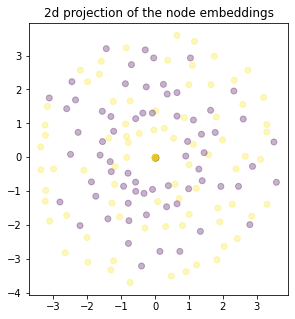

In [56]:
# viz

node_embeddings = model.wv.vectors
node_types = [G.node_type(node_id) for node_id in model.wv.index_to_key]

from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt


node_embeddings_2d = MDS(n_components=2, metric='cosine').fit_transform(node_embeddings)
node_embeddings_2d

label_map = {l: i for i, l in enumerate(np.unique(node_types))}
node_colors = [label_map[t] for t in node_types]

plt.figure(figsize=(5, 5))
plt.axes().set(aspect='equal')
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colors, alpha=0.3)
plt.title('2d projection of the node embeddings')
plt.show()